## Imports & things to run at start

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import importlib

In [2]:
user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

In [3]:
# constants
csts = dict()
csts['k'] = 1.380649e-23  # J/K
csts['A'] = 3.15*0.92*1e-6  # m
csts['L'] = 10.00e-3  # m

## Functions

#### Plotting raw data, V vs 1/T

In [4]:
def plot_voltage_temp(dataset, title = ''):
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    fig, axs = plt.subplots(4, 2, figsize=(8, 8), dpi=200)
    fig.suptitle(title)

    for i in range(1, 8):
        ax = axs[(i-1)//2, (i-1)%2]
        ax.errorbar(1/dataset['T'], np.log(np.abs(1/dataset[f'v{i}'])), markersize=1, xerr=0.0001 / dataset['T']**2, yerr=0.0000001 / dataset[f'v{i}'], fmt = '.', alpha = 0.5, color = 'black', label = '')
    
        ax.set_title(f'v{i}')

    fig.supxlabel('1/T (1/K)')
    fig.supylabel('ln(1/V)')
    plt.tight_layout()
    plt.show() 

#### Interpolation

In [5]:
def interp_data(dataset, new_file):
    interp_dataset = dict()
    common_time = dataset["t9"]  # using time of temperature readings

    interp_dataset['t'] = common_time

    for i in range(1, 8):
        interp_data = interp1d(dataset[f't{i}'], dataset[f'v{i}'], bounds_error=False, fill_value="extrapolate")
        interp_dataset[f'v{i}'] = interp_data(common_time)

    np.savez(f'interpolated_data/{new_file}_copy.npz', interp_dataset)
    interp_dataset['T'] = dataset['T']
    return interp_dataset

#### Plot with linear fit

Computing what the errors should be due to error propagation: 

Error in temperature: x = 1/T, so error goes as:
$(1/T)_{err}= (1/T) * T_{err} / T = T{err}/T^2$

Error in voltage: y = ln(1/V), and dy/dV = -1/V, so

$y_{err} = (1/V)_{err} / (1/V) = V{err}/V^2 / 1/V = V{err} /V$


In [23]:
def linear_fit(data_dict, voltage_channel, applied_current, csts=csts):
    importlib.reload(plt)
    T = data_dict['T'] + 273.15  # K
    V = data_dict[voltage_channel]  

    plt.figure(figsize=(8, 4), dpi=200)
    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

    # Plot the original data points
    plt.errorbar(1/T, np.log(np.abs(1/V)), xerr=0.0001 / T**2, yerr=0.0000001 / V, fmt='o', markersize=1, label=f'Voltage across {voltage_channel} connection', alpha=0.5, zorder = 1, color = 'black')
    plt.xlabel('1/T (1/K)')
    plt.ylabel('ln(1/V)')

    # Perform a linear fit on the specified section of the data
    coefficients, cov_mtx = np.polyfit(1/T[0:12], np.log(np.abs(1/V[0:12])), 1, cov = True)  # highest power first
    polynomial = np.poly1d(coefficients)

    # getting errors from fit
    std_errs = np.sqrt(np.diag(cov_mtx))

    # Compute the band gap energy and conductivity from the fit
    Eg = -coefficients[0]*2*csts['k']*6.242e18  # eV
    sigma = applied_current*1e-3*csts['L']*np.exp(coefficients[1])/csts['A']  # 1e-3 to convert current from mA to A!!

    # convert the errors to the desired units
    Eg_err = 2*csts['k']*6.242e18*std_errs[0]
    sigma_err = applied_current*1e-3*csts['L']*np.exp(coefficients[1])*std_errs[1]/csts['A']

    # Generate x values for the fitted line
    T_fit = np.linspace((1/T).min(), 1/T[12],  100)
    V_fit = polynomial(T_fit)

    # Plot the fitted line on top of the original data points
    plt.plot(T_fit, V_fit, label='Linear Fit', color='red')
    plt.legend(loc='upper right')

    # plot residuals for the area of the fit
    plt.figure(figsize=(8, 4), dpi=200)
    plt.scatter(1/T[:12], np.log(np.abs(1/V[:12])) - polynomial(1/T[:12]), s=1,  label='Residuals', zorder = 1, color = 'black')
    plt.xlabel('1/T (1/K)')
    plt.ylabel('Residuals')
    plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
    plt.legend(loc='best')
    plt.show()

    return Eg, sigma, Eg_err, sigma_err

## Load Data

In [24]:
# No magnet or magnetic field
onemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/1mA_no_magnet_3.csv', header=2)
threemA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/3mA_no_magnet.csv', header=2)
tenmA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/10mA_no_magnet.csv', header=2)
thirtymA_no_magnet = pd.read_csv(user_path+'/PHYS469/hall_experiment/09052024/30mA_no_magnet.csv', header=2)

## 1. No Heating or Magnetic field

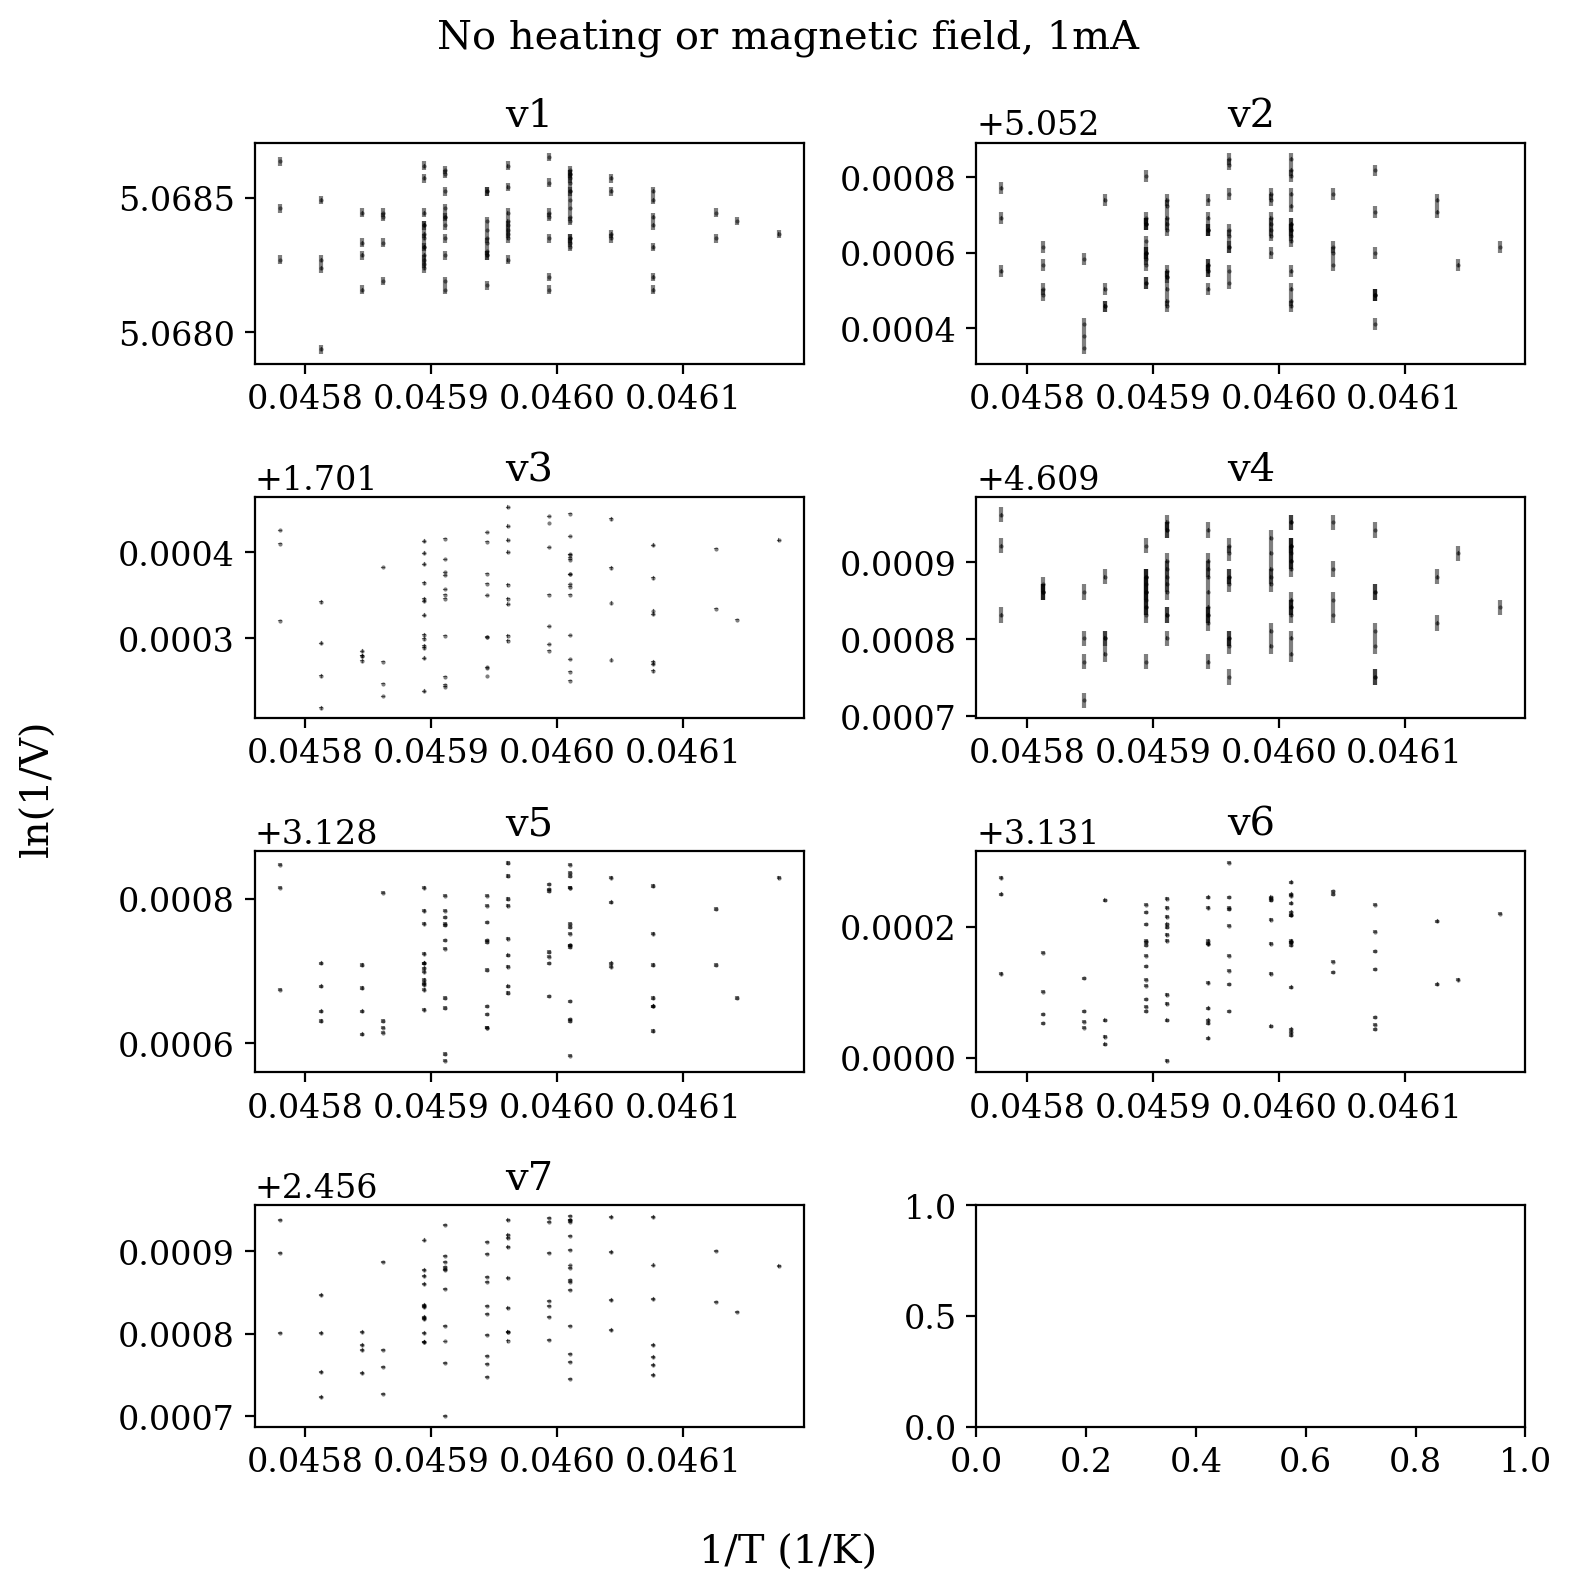

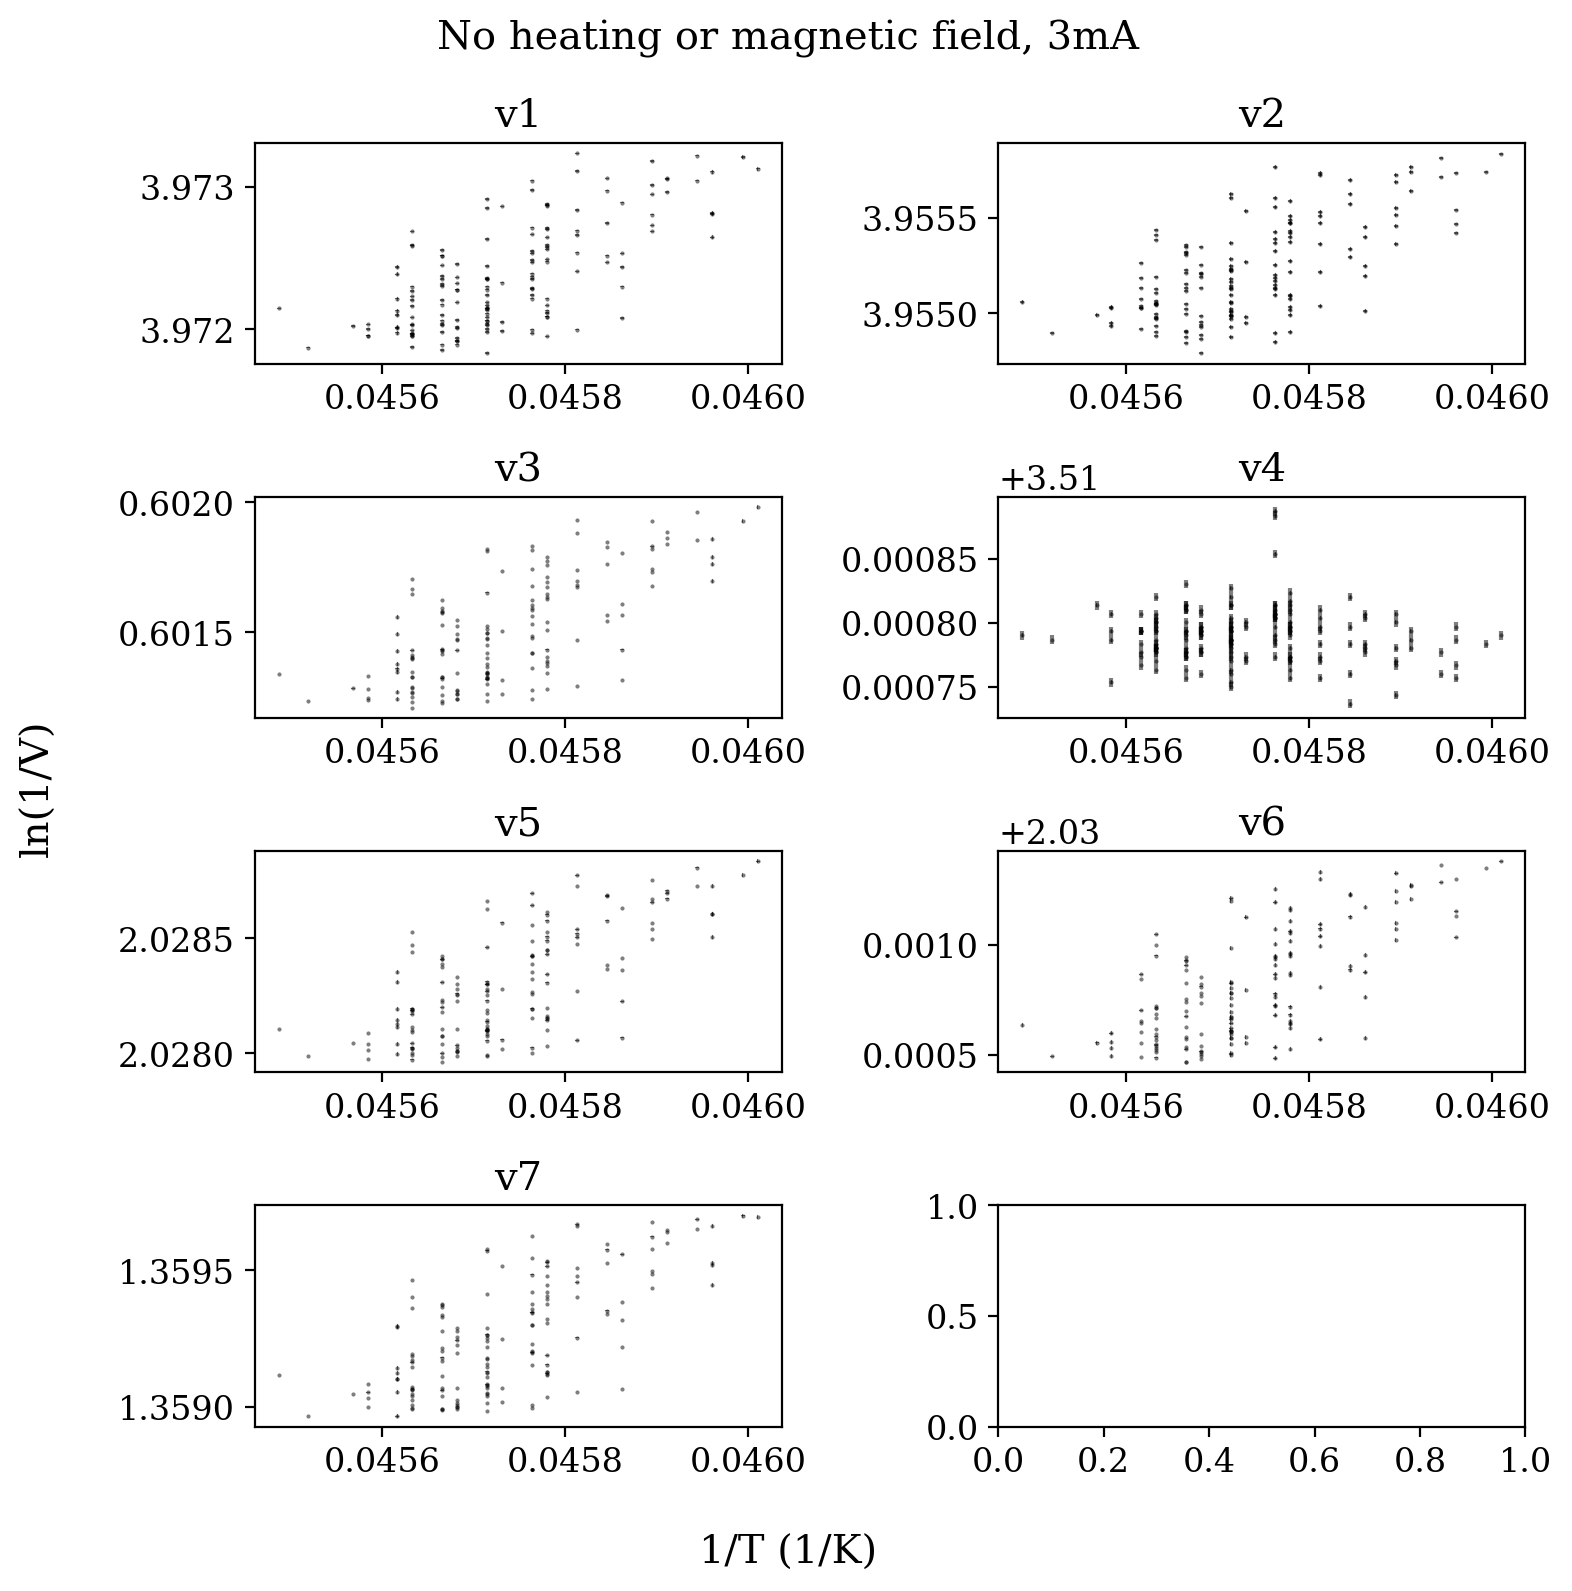

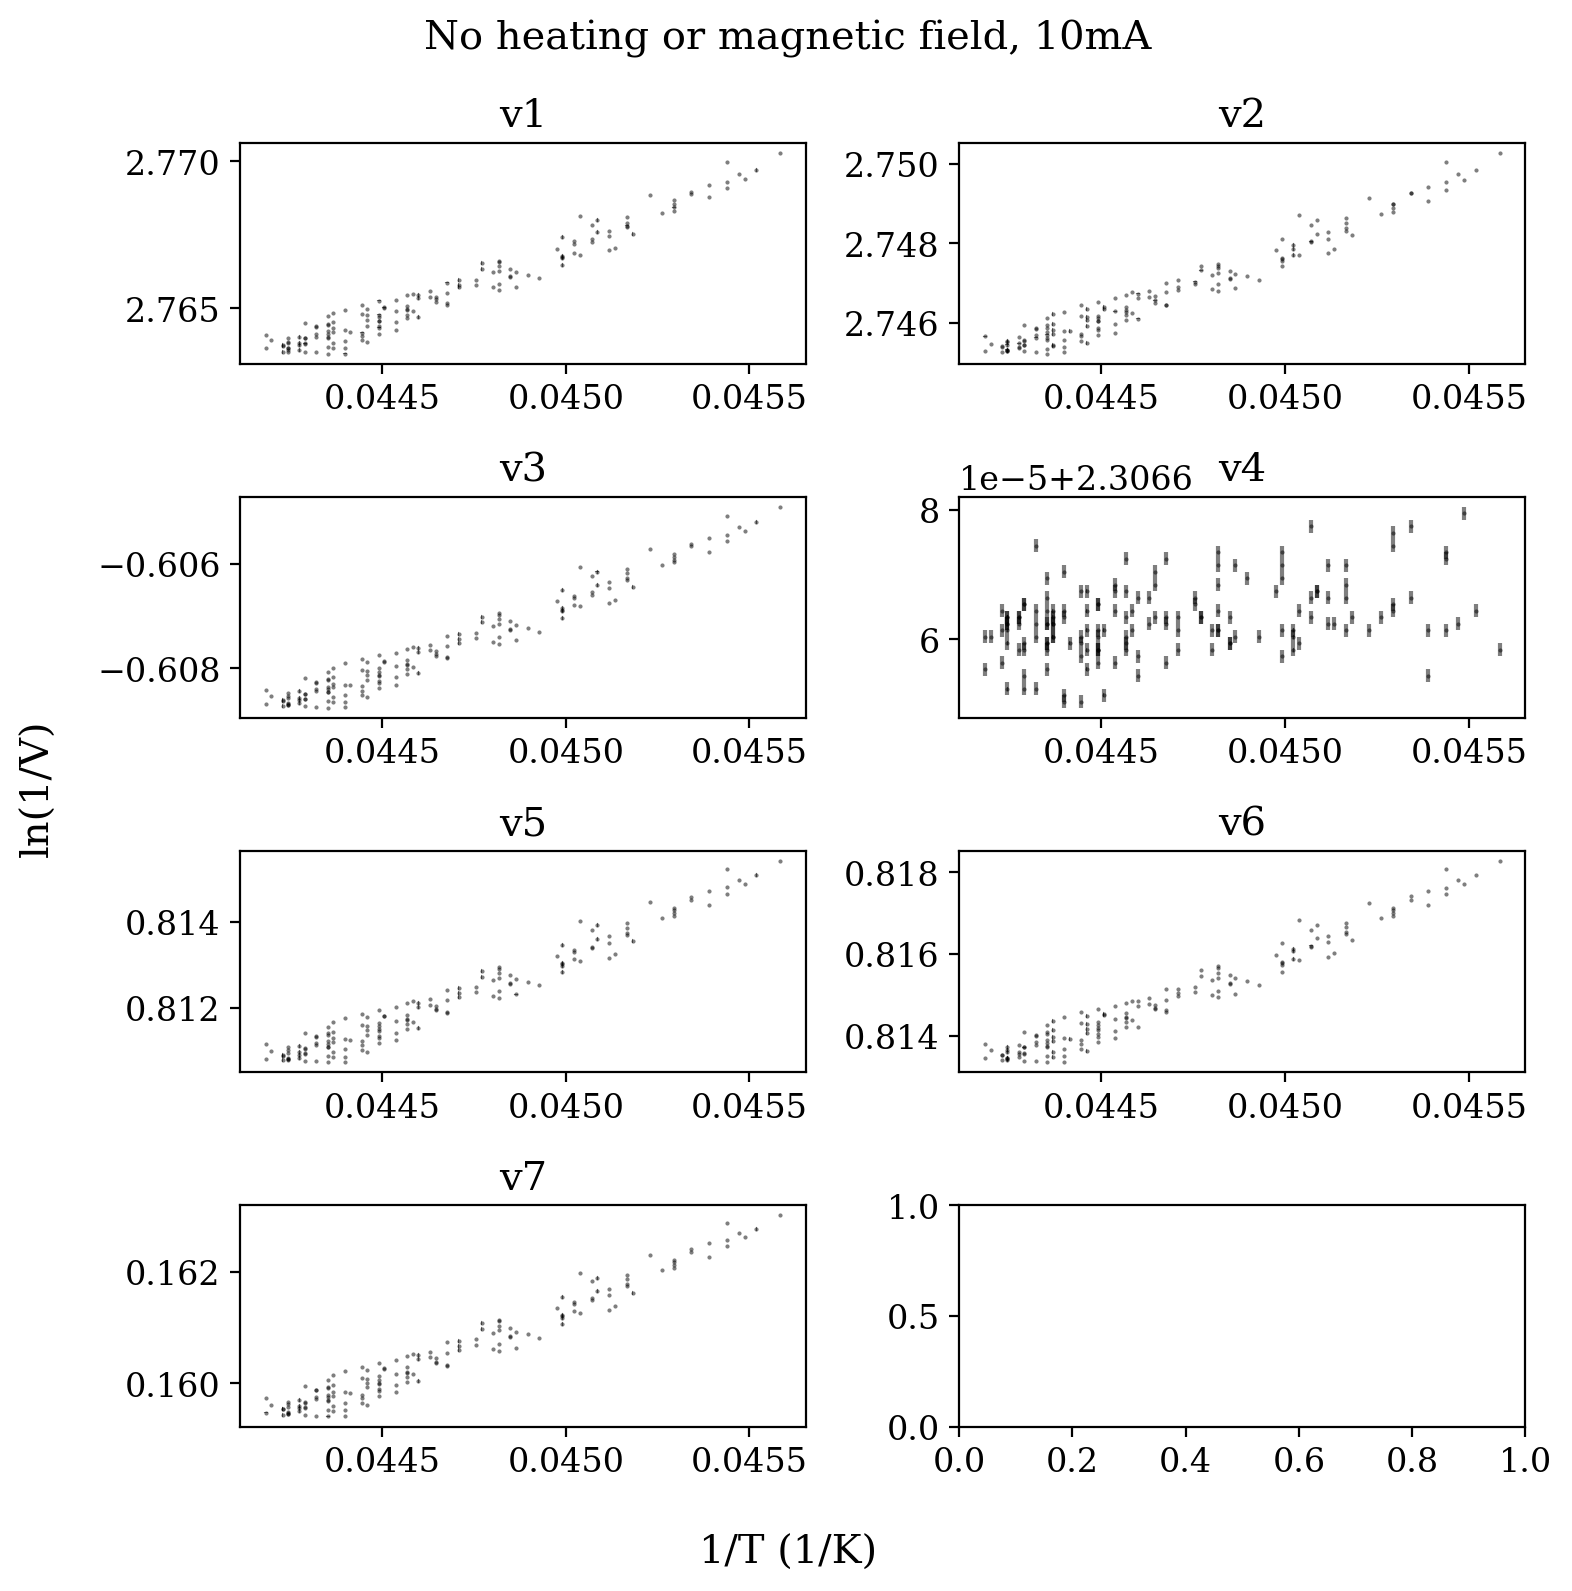

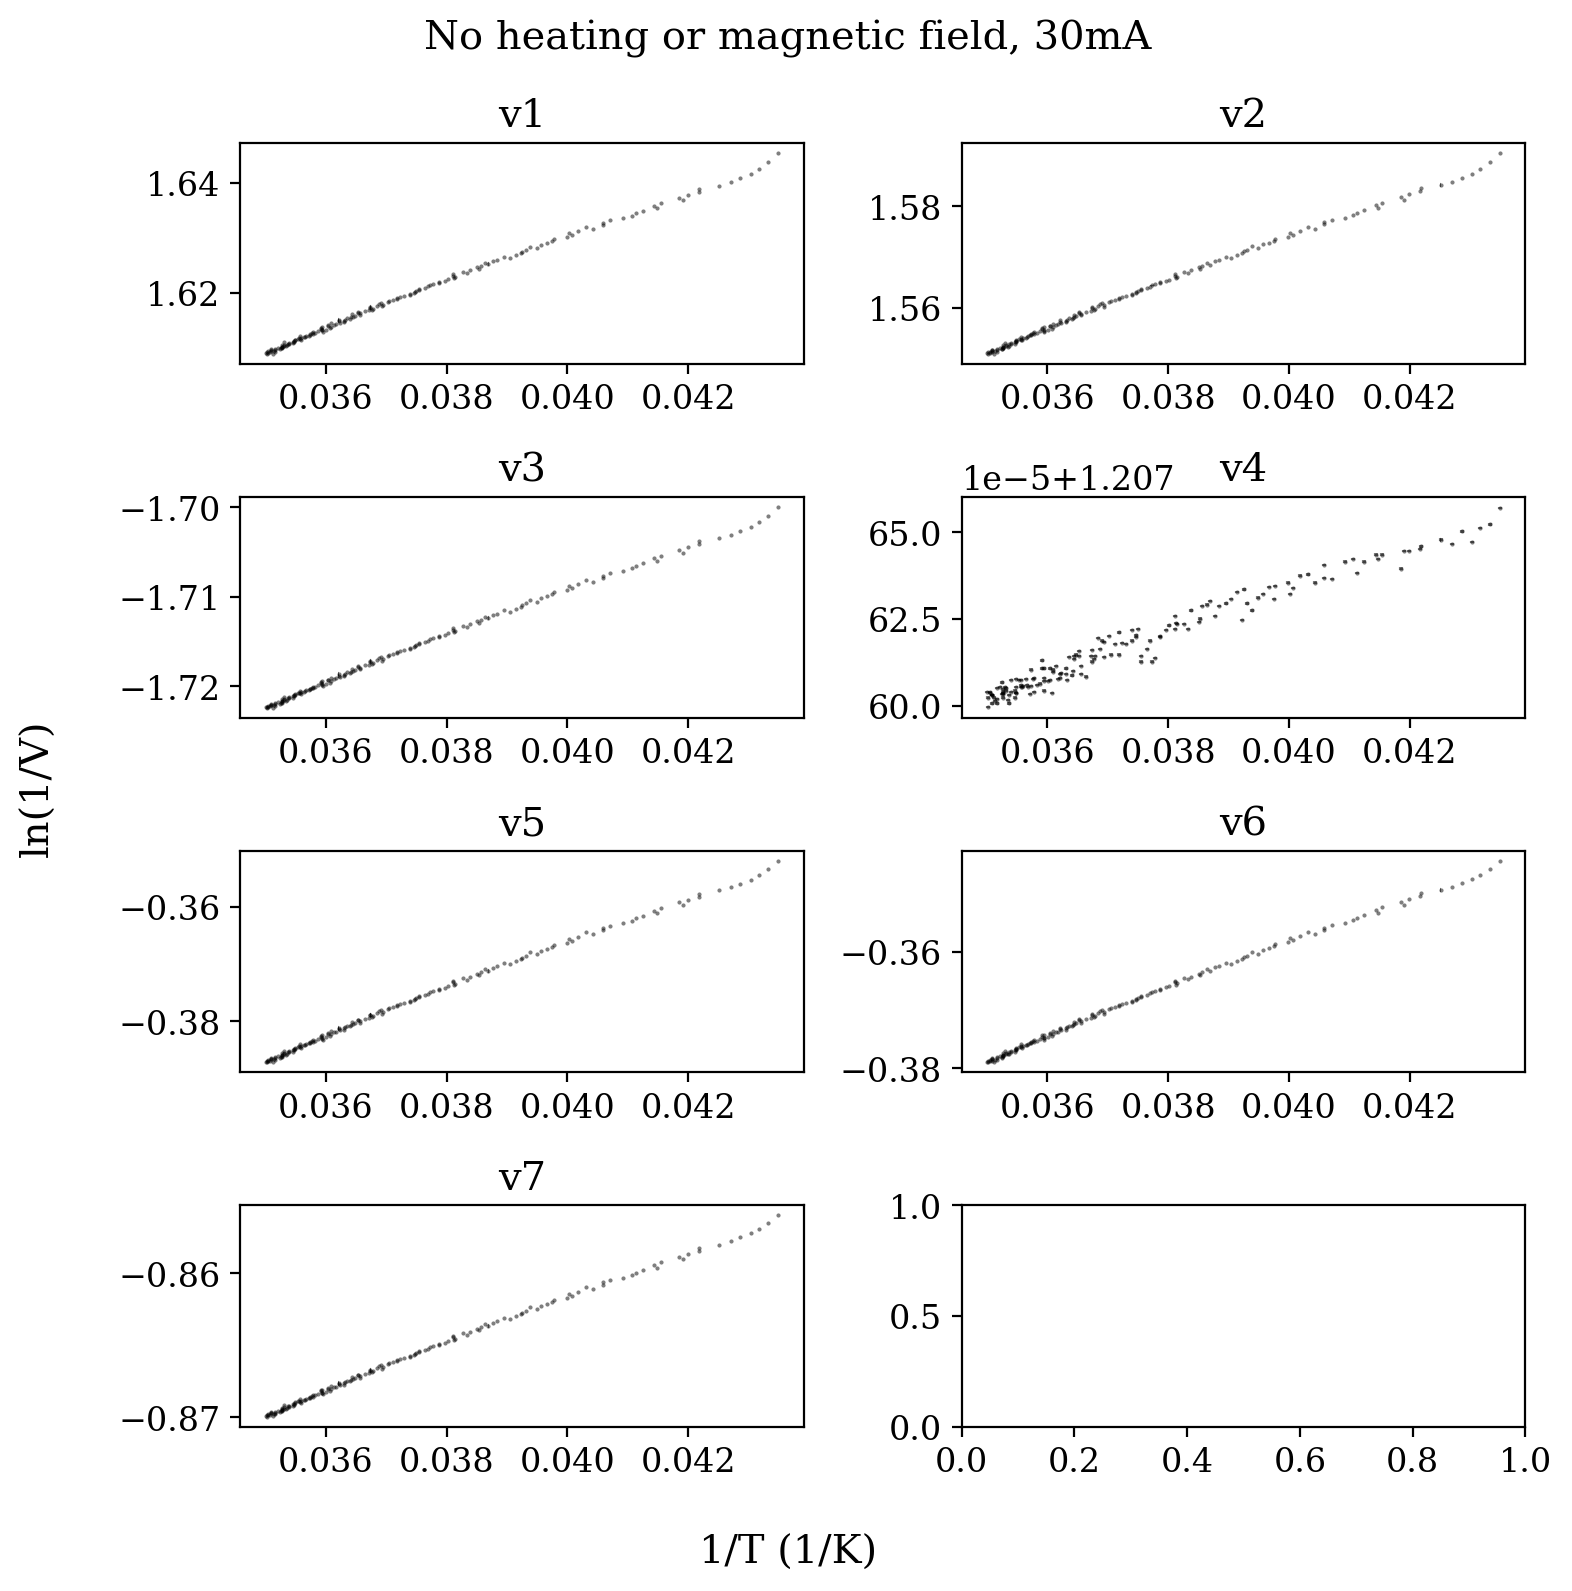

In [25]:
plot_voltage_temp(onemA_no_magnet, 'No heating or magnetic field, 1mA')
plot_voltage_temp(threemA_no_magnet, 'No heating or magnetic field, 3mA')
plot_voltage_temp(tenmA_no_magnet, 'No heating or magnetic field, 10mA')
plot_voltage_temp(thirtymA_no_magnet, 'No heating or magnetic field, 30mA') 

## Interim Report Plots

### Raw measurement plot

In [26]:
# loading one of the heated, magnetic field datasets we took on the 12th
data_run = '300mV_10mA_heating'
data_path = user_path+f'/PHYS469/hall_experiment/09122024/{data_run}.csv'
data_csv = pd.read_csv(data_path, header=2)
data_dict = interp_data(data_csv, data_run)

fitting the linear part of the data

$$ \sigma = \frac{IL}{VA} = \sigma_o \exp(\frac{-Eg}{2kT})$$

so if we plot ln(1/V) vs 1/T, we should get a straight line

In [27]:
# are we using hall voltage or voltage along the current...? 
# hall voltage is on V1 and V2

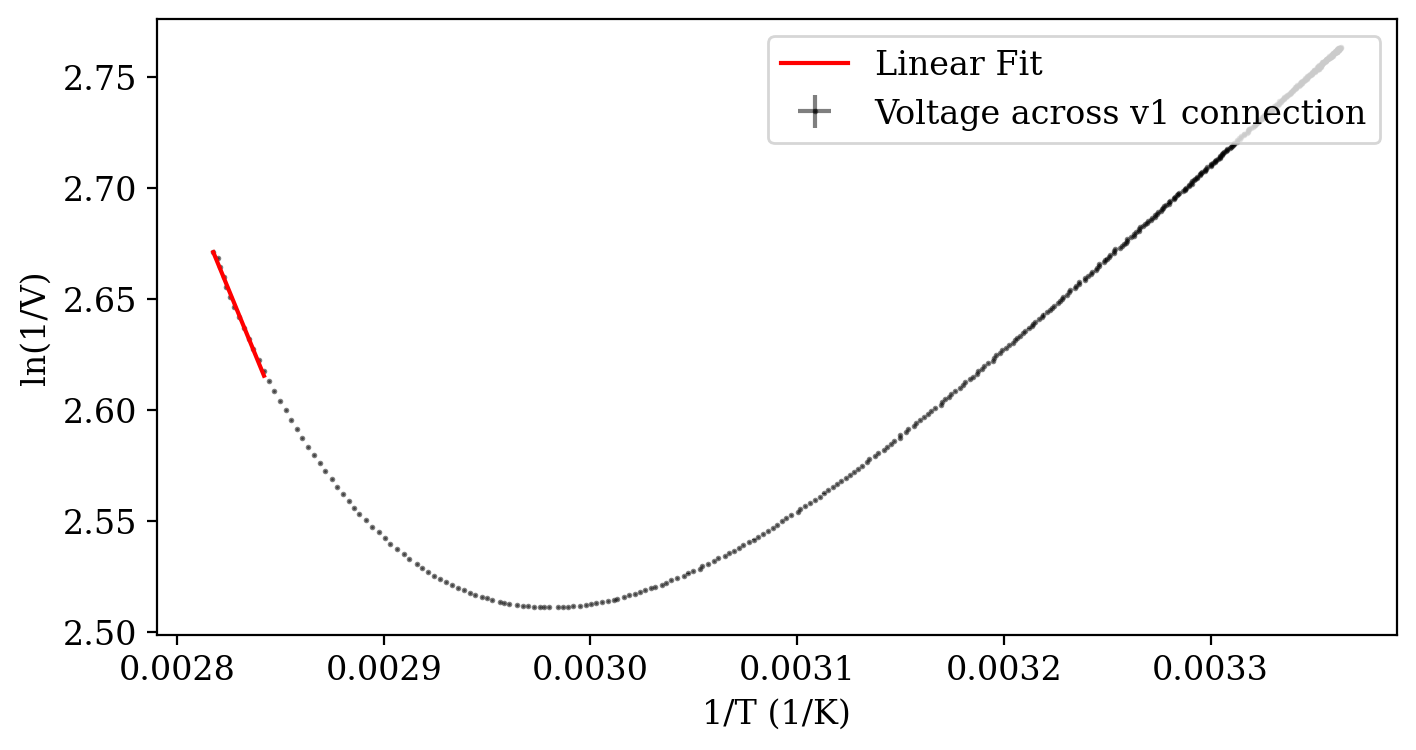

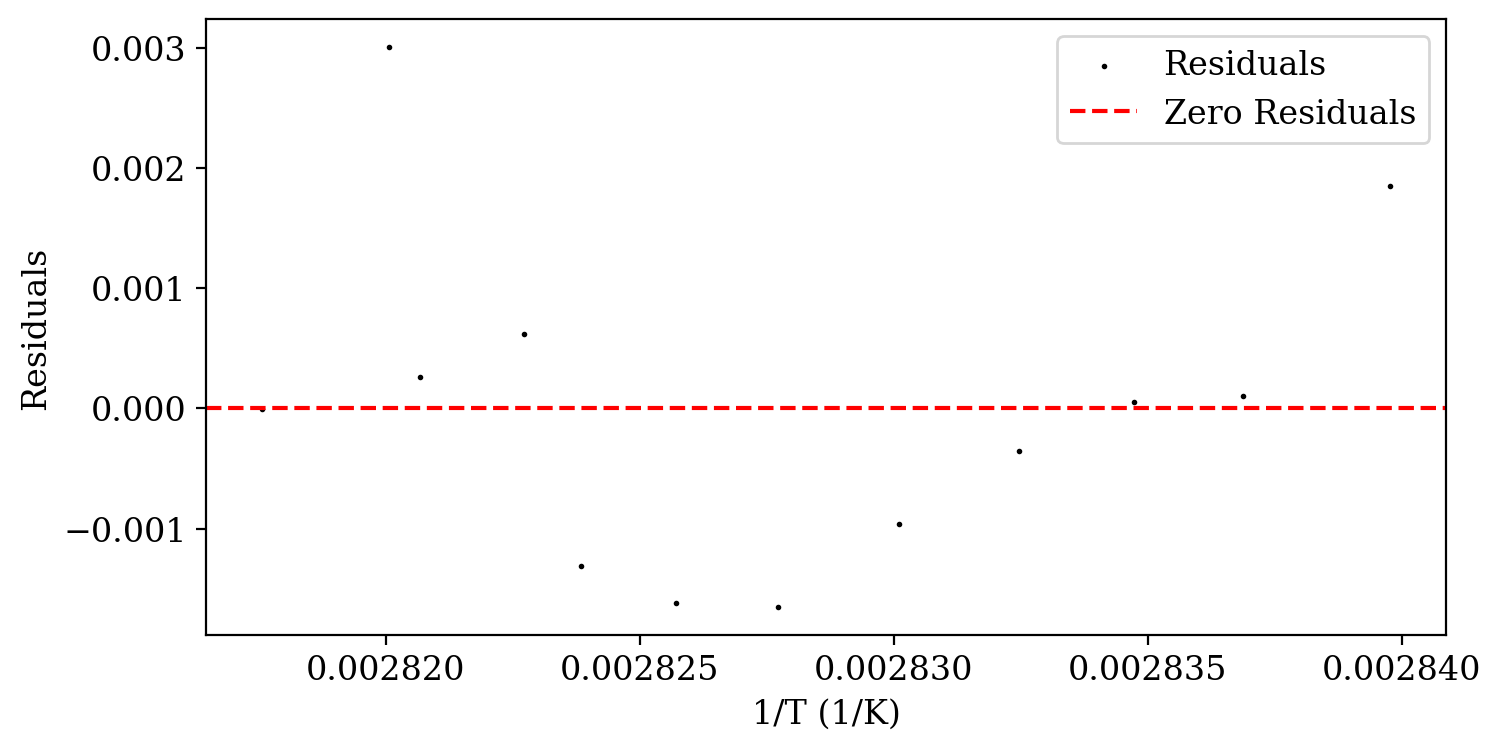

In [28]:
Eg_300mV_10mA_heating_V1, sigma_300mV_10mA_heating_V1, Egerr_300mV_10mA_heating_V1, sigmaerr_300mV_10mA_heating_V1  = linear_fit(data_dict, 'v1', applied_current=10)

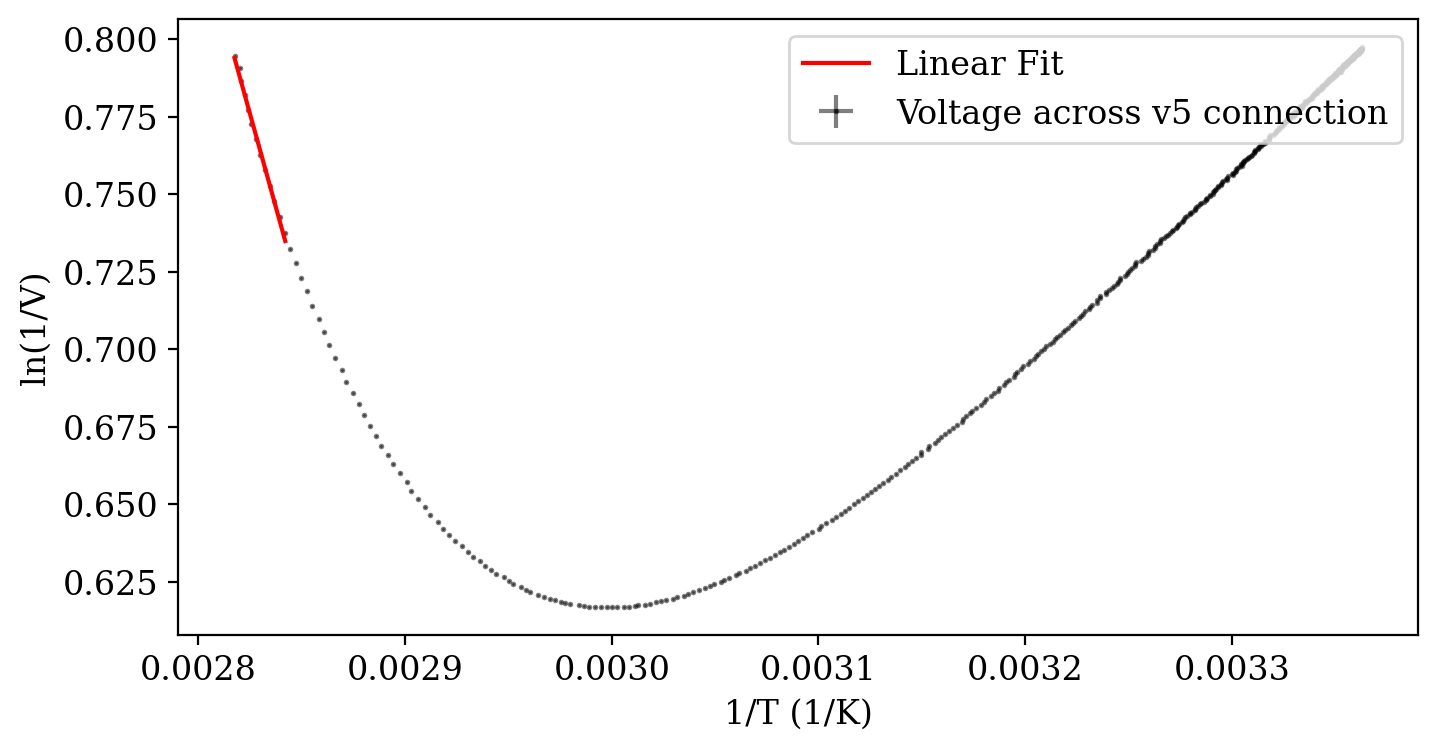

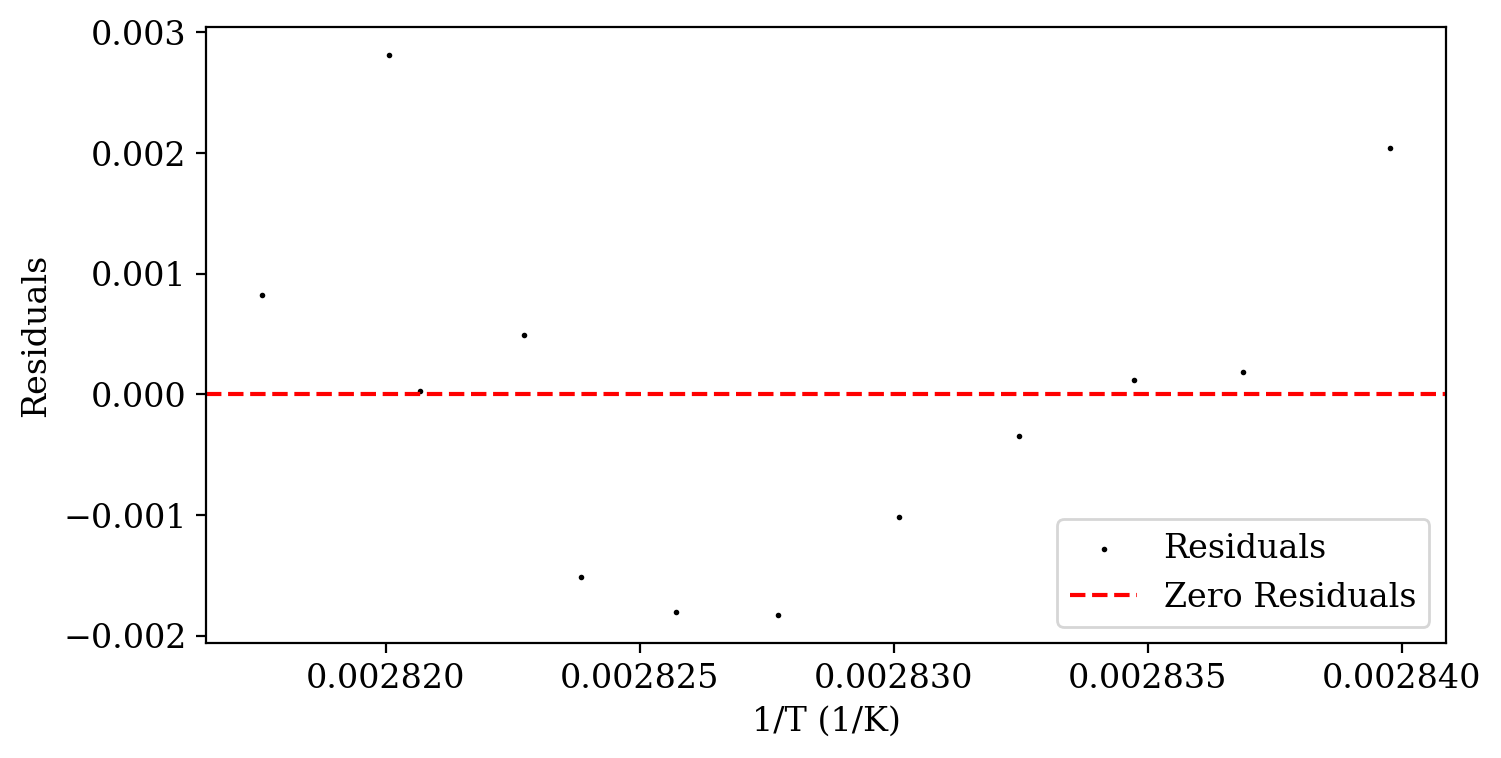

Band gap energy: 0.41464925400695135 eV
Intrinsic conductivity: 67054.90015612701
Errors: 0.011051440227610329 eV, 12157.517357691666


In [29]:
Eg_300mV_10mA_heating_V5, sigma_300mV_10mA_heating_V5, Egerr_300mV_10mA_heating_V5, sigmaerr_300mV_10mA_heating_V5 = linear_fit(data_dict, 'v5', applied_current=10)
print(f'Band gap energy: {Eg_300mV_10mA_heating_V5} eV')
print(f'Intrinsic conductivity: {sigma_300mV_10mA_heating_V5}')
print(f'Errors: {Egerr_300mV_10mA_heating_V5} eV, {sigmaerr_300mV_10mA_heating_V5}')

# need to add errors on these values, idk how to get the from the fit


# FOR AUDREY;
# I think the uncertainty on the Thermocouple is 0.0001, and 0.0000001 on V1

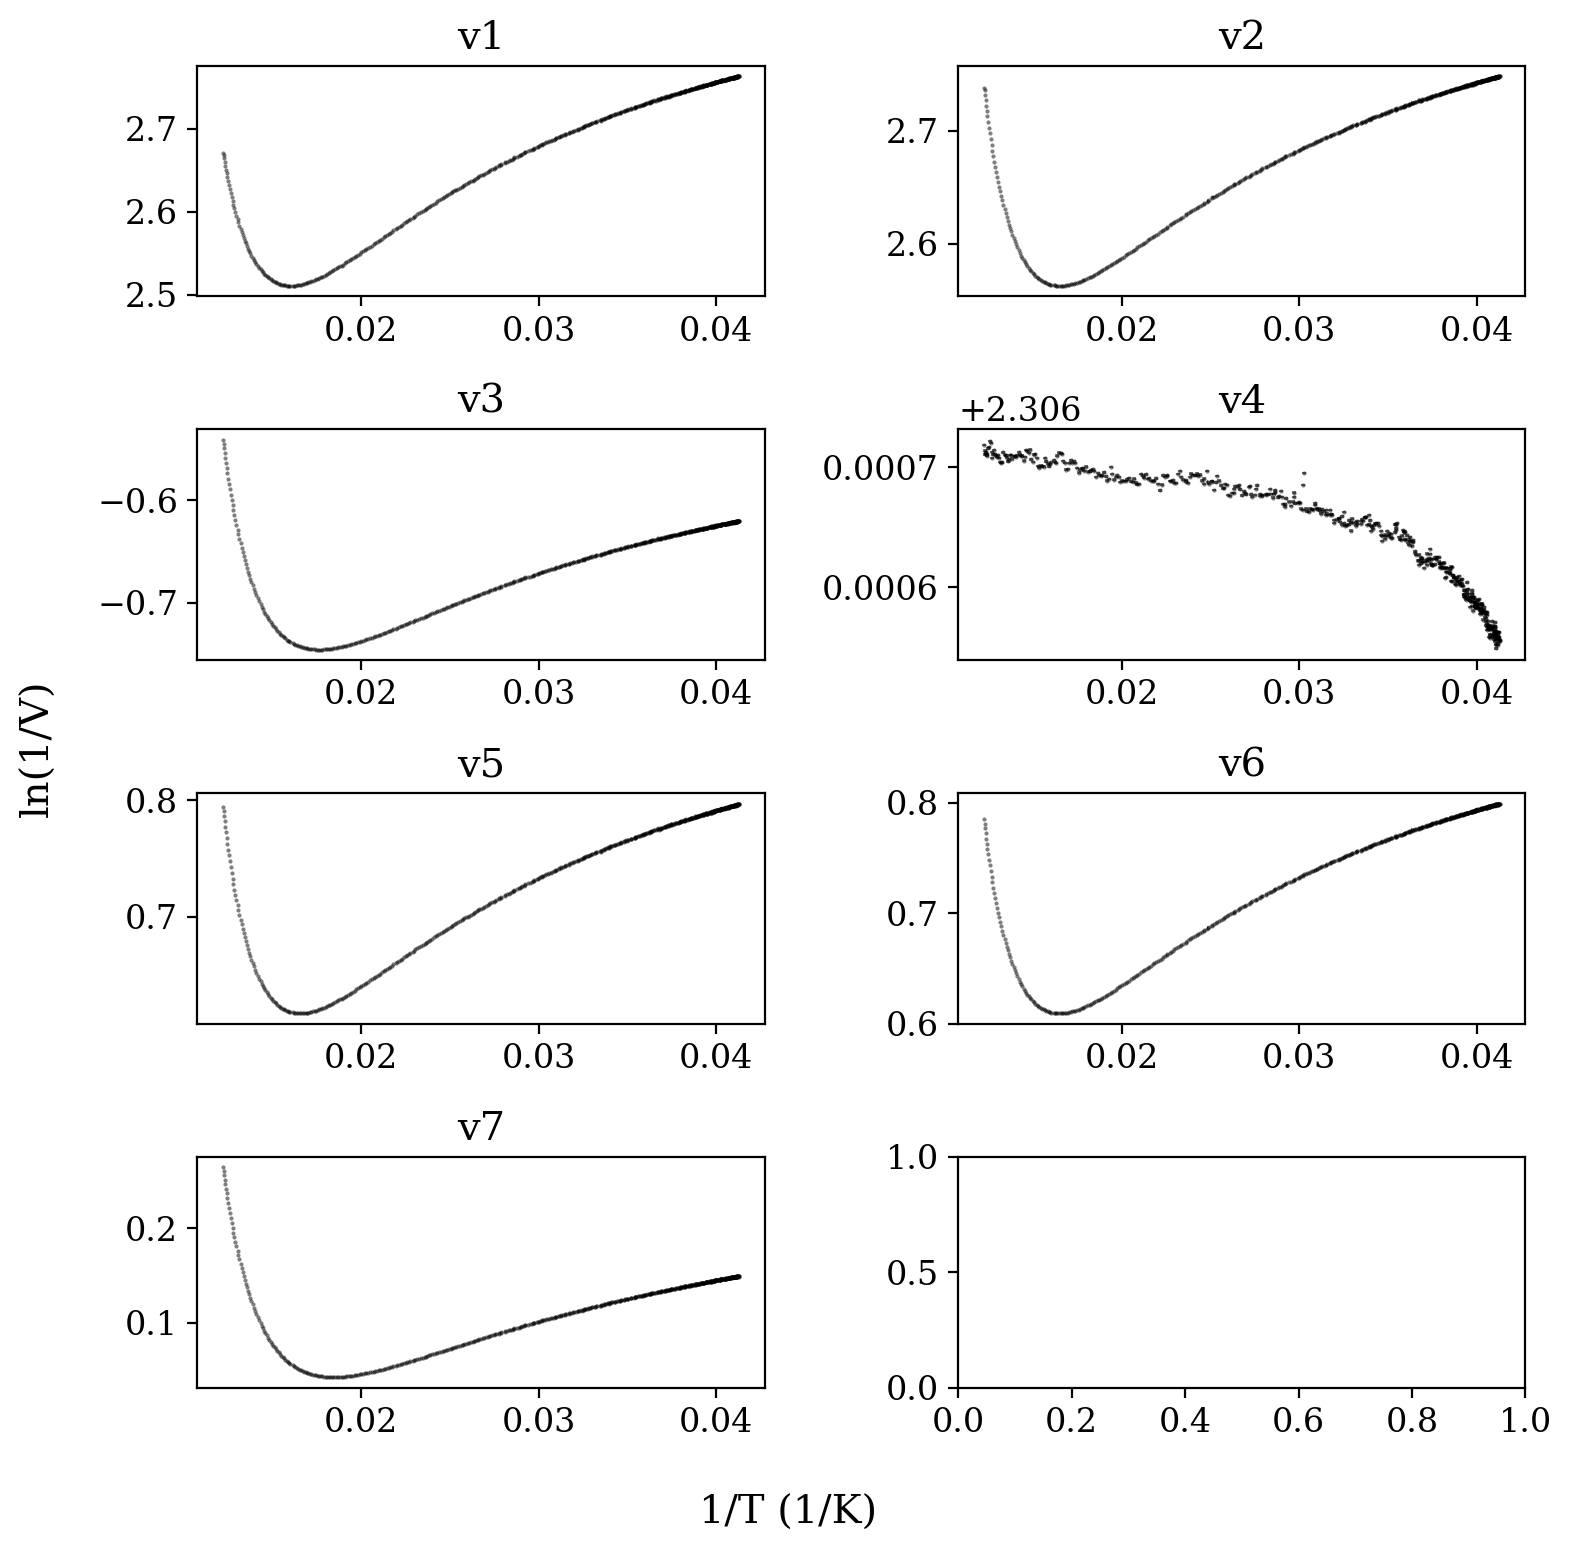

In [30]:
plot_voltage_temp(data_dict)

<!--  -->

TO DO: 
- calculate the base conductivity
- calculate the band gap energy